Load data

In [1]:
import pandas as pd

In [2]:
data = pd.read_pickle('combined_data.pkl')
data.sample()

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
18053,8053,33894.0,622413.0,495000.0,261000.0,0.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.shape

(20000, 768)

It's a little painful to type (and read) the column names in UPPER CASE.  Let's make them lowercase. 

In [4]:
df = data.copy()
df = df.rename(columns=lambda x: x.lower())
df.sample()

,index,amt_annuity,amt_credit,amt_goods_price,amt_income_total,amt_req_credit_bureau_day,amt_req_credit_bureau_hour,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_week,...,cc_name_contract_status_signed_max,cc_name_contract_status_signed_mean,cc_name_contract_status_signed_sum,cc_name_contract_status_signed_var,cc_name_contract_status_nan_min,cc_name_contract_status_nan_max,cc_name_contract_status_nan_mean,cc_name_contract_status_nan_sum,cc_name_contract_status_nan_var,cc_count
7037,7037,30204.0,450000.0,450000.0,67500.0,0.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We know apriori that there are null values in the entries.  Let us just find out which coulms contain any null value. 

In [5]:
has_null = [col for col in df.columns 
            if sum(df[col].isnull())]

len(has_null)

586

We have to impute the missing (null) values.  However, the imputation strategy may be different based on the datatype.  Let's find which missing columns are numerical and which are categorical. 

In [6]:
has_null_num = [col for col in has_null 
                if df[col].dtype == 'float']

len(has_null_num)

586

Looks like all the missing-value columns are numerical.  For simplicity we shall replace the missing values of a column by the mean of that column.  Before we move on though, we whould be wary of missing values in the target column.  Let's see if there are any.  

In [7]:
'target' in has_null

True

In [8]:
sum(df['target'].isnull())

10000

Wow! Almost half of the entries!  Let's just drop theose entries for the purpose of supervised learning.  We may reconsider dropping if we want to combine some form of unsupervised learning later. 

In [9]:
df = df[df['target'].notnull()]
df.shape

(10000, 768)

In fact, we should convert the target to boolean. 

In [10]:
df['target'] = df['target'].astype('bool')

In [11]:
df['target'].value_counts()

False    9225
True      775
Name: target, dtype: int64

Let's just subsample so that we have equal number of False and True cases.  

In [13]:
from sklearn.model_selection import train_test_split

In [16]:
df_False = df[df['target'] == False]
df_True  = df[df['target'] == True]

df_False = df_False.sample(775)
df_subsample = df_False.append(df_True)
df_subsample.shape

(1550, 768)

Now fill in the missing values with means.  

In [17]:
for col in has_null:
    df_subsample[col] = df_subsample[col].fillna(df_subsample[col].mean())

Let's check if we have any more null values.  

In [18]:
has_null = [col for col in df_subsample.columns 
            if sum(df_subsample[col].isnull())]

len(has_null)

29

Surprise!  We still have 29 of them.  Why's that?  Let's see. 

In [19]:
has_null

['buro_amt_annuity_max',
 'buro_amt_annuity_mean',
 'buro_months_balance_min_min',
 'buro_months_balance_max_max',
 'buro_months_balance_size_mean',
 'buro_status_0_mean_mean',
 'buro_status_1_mean_mean',
 'buro_status_2_mean_mean',
 'buro_status_3_mean_mean',
 'buro_status_c_mean_mean',
 'buro_status_x_mean_mean',
 'buro_status_nan_mean_mean',
 'active_amt_annuity_max',
 'active_amt_annuity_mean',
 'active_months_balance_min_min',
 'active_months_balance_max_max',
 'active_months_balance_size_mean',
 'closed_amt_annuity_max',
 'closed_amt_annuity_mean',
 'closed_months_balance_min_min',
 'closed_months_balance_max_max',
 'closed_months_balance_size_mean',
 'refused_app_credit_perc_var',
 'refused_amt_down_payment_min',
 'refused_amt_down_payment_max',
 'refused_amt_down_payment_mean',
 'refused_rate_down_payment_min',
 'refused_rate_down_payment_max',
 'refused_rate_down_payment_mean']

In [23]:
df_subsample['buro_amt_annuity_max'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buro_amt_annuity_max, dtype: float64

So the problem is that they are all filled with missing values.  Just drop them.  

In [24]:
df_subsample = df_subsample.drop(has_null, axis=1)

(10000, 768)

In [25]:
df_subsample.shape

(1550, 739)

Did it work?  Let's verify. 

In [26]:
[col for col in df_subsample.columns if sum(df_subsample[col].isnull())]

[]

Great!  Let's now move on to modeling.  

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
y = df_subsample['target']
X = df_subsample.drop('target', axis=1)

In [29]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

The data is definitely high dimensional and hence expected to be sparse.  We could start with Naive Bayes.   

### Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.4639175257731959

Quite low!

In [32]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)

In [33]:
con_mat

array([[177,   0],
       [208,   3]])

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

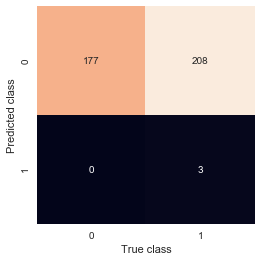

In [35]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5071090047393365

### Logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
ypred = lr.predict(Xtest)

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.45618556701030927

Pretty low!

In [39]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[177,   0],
       [211,   0]])

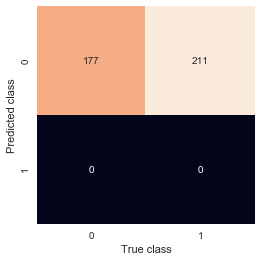

In [40]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5

### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.5773195876288659

Still low!

In [44]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[112,  65],
       [ 99, 112]])

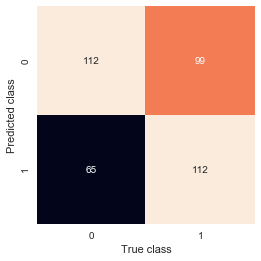

In [45]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

In [46]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5817870243928562

#### Adaboost

In [56]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

In [57]:
abc.fit(Xtrain, ytrain)
ypred = abc.predict(Xtest)

In [58]:
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[108,  69],
       [ 68, 143]])

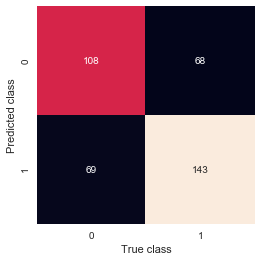

In [59]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

In [50]:
roc_auc_score(ytest, ypred)

0.6463169732508633

#### GBT

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
abc.fit(Xtrain, ytrain)
ypred = abc.predict(Xtest)

In [61]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[108,  69],
       [ 68, 143]])

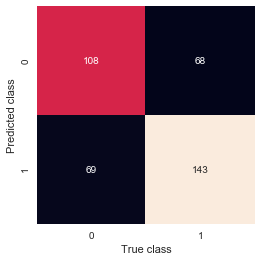

In [62]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

In [63]:
roc_auc_score(ytest, ypred)

0.643947305004418

Okay things are BAD!  